# Start of modelling

In [16]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import mean_squared_error

### Loading data and changing it to be usable

In [17]:
# Read datafile
file_path = "C:/Users/hidde/Documents/Uni/Erasmus/Blok 3/Project/Complete_dataset.csv" # Change the file path depending on where you saved the file
data = pd.read_csv(file_path)

In [18]:
# Transfer to date variable and set it as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
# Replace na with 0
data.fillna(0, inplace=True)

In [19]:
# Create list with names of all variables
all_predictors = data.columns.drop(['RET', 'Month', 'permno'])
# Save the return
y_variable = ['RET']


### Characteristics of OLS-3
OLS-3 includes size = 'mvel1', Book-to-Market = 'bm', momentum = 'mom12m' Does it also include 'mom1m','mom6m','mom12m','mom36m'?

In [20]:
# Create Dataset for OLS-3 (Need to determine the momentum variable!)
three_predictors_and_return = ['mvel1', 'bm','mom12m', 'RET']
three_predictors = ['mvel1', 'bm','mom12m']
data3 = data[three_predictors_and_return]

In [21]:
# Look at dataset with only 3 predictors
data3

,mvel1,bm,mom12m,RET
Date,,,,
1957-01-01,1.220639e+07,0.000000,-0.016260,-0.082386
1957-01-01,1.153415e+07,0.000000,0.143456,-0.017021
1957-01-01,1.077829e+07,0.000000,0.012912,0.031364
1957-01-01,8.769161e+06,0.000000,-0.186409,-0.045396
1957-01-01,5.225362e+06,0.000000,0.051821,-0.107884
...,...,...,...,...
2016-12-01,1.022451e+07,-0.000213,0.152332,0.074279
2016-12-01,1.021339e+07,0.544931,0.039258,-0.034056
2016-12-01,1.020248e+07,0.280728,0.171187,-0.028373


### OLS(-3) Regression with expanding window and with and without Huber loss

In [67]:
# Function that runs OLS with an expanding windows
# Input: 
#   data: dataframe, 
#   y_variable: name of y variable
#   X_variable: names of x variables
#   loss: Specify if you want to use 'OLS' loss, or 'Huber' loss
# Output: list of mse_scores, (access by: expanding_regression_OLS()[0]), and list of r_squared_scores, (access by: expanding_regression_OLS()[1]) 

train_years = 18
validation_years = 12
test_years = 1

def expanding_regression_OLS(data, y_variable, x_variables, loss = 'OLS'):
    
    mse_scores = []
    r_squared_scores = []
    years = data.index.year.unique()

    for i in range(len(years) - train_years - validation_years): # i is 0 to the last start_year which is the last year minus the start training years and validation years.
        start_year = years[i]
        end_train_year = start_year + train_years  # 18 years of training and increasing with 1 year every iteration
        end_validation_year = end_train_year + validation_years  # 12 years of validation
        end_test_year = end_validation_year + test_years  # 1 year of test

        # Creating data frames for training, validation and testing.
        train_data = data[(data.index.year < end_train_year)]
        #val_data = data[(data.index.year >= end_train_year) & (data.index.year < end_validation_year)]
        test_data = data[(data.index.year >= end_validation_year) & (data.index.year < end_test_year)]

        X_train = train_data[x_variables]
        X_test = test_data[x_variables]
        y_train = train_data[y_variable].values.ravel()
        y_test = test_data[y_variable].values.ravel()
           
        if loss == 'OLS':
            model = LinearRegression()
        elif loss == 'Huber':
            model = HuberRegressor(epsilon = 1e6) # Set the epsilon to a very big value. Infinite is not supported.
        else:
            raise ValueError("Invlaid loss function. Use OLS or Huber.")
    
        model.fit(X_train, y_train)

        # Predict on test set
        y_pred = model.predict(X_test)

        # Calculate MSE
        mse = np.mean((y_pred - y_test) ** 2)
        mse_scores.append(mse)

        # Calculate R_squared
        r_squared = model.score(X_test, y_test)
        r_squared_scores.append(r_squared)
    
    return mse_scores, r_squared_scores

-0.027886363618365665


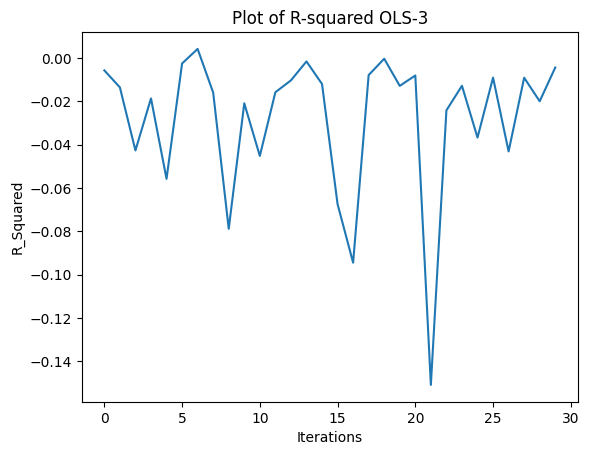

In [68]:
# Get mean r-squared for OLS-3
r_squared_scores = expanding_regression_OLS(data3, y_variable, three_predictors)[1]
print(np.mean(r_squared_scores)) # -0.027886

#Plot R-Squared
plt.plot(r_squared_scores)
# Adding labels and title
plt.xlabel('Iterations')
plt.ylabel('R_Squared')
plt.title('Plot of R-squared OLS-3')
# Display the plot
plt.show()

-0.03291973886859768


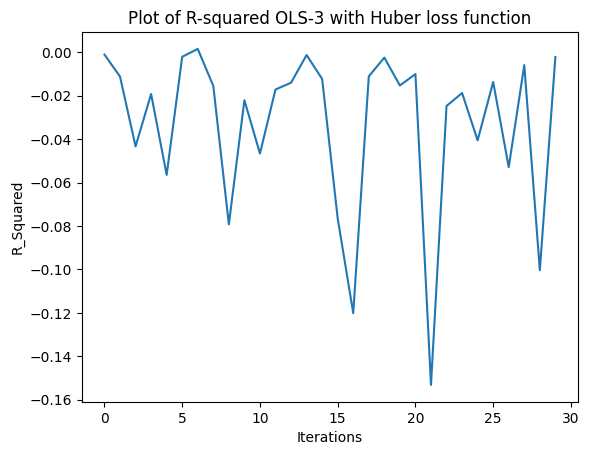

In [69]:
# Get mean r-squared for OLS-3 with Huber Loss function
r_squared_scores = expanding_regression_OLS(data3, y_variable, three_predictors, loss = 'Huber')[1]
print(np.mean(r_squared_scores)) # 

#Plot R-Squared
plt.plot(r_squared_scores)
# Adding labels and title
plt.xlabel('Iterations')
plt.ylabel('R_Squared')
plt.title('Plot of R-squared OLS-3 with Huber loss function')
# Display the plot
plt.show()

In [ ]:
# Get mean r-squared for full OLS (10m runtime)
# print(f"The mean R-Squared for the full dataset is: {np.mean(expanding_regression_OLS(data, y_variable, all_predictors)[1])}") #-1725.3562


The mean R-Squared for the full dataset is: -17245.35622453705
